In [1]:
#%pip install scikit-learn
#%pip install matplotlib-venn

In [2]:
import pandas as pd

import torch
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, pipeline
from sklearn.metrics import accuracy_score, f1_score
import json
from datasets import load_dataset, Split

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#rlhf = 'anime'
# rlhf = 'steam' 
rlhf = 'movie'

In [4]:
dataset = load_dataset("csv", data_files=f"{rlhf}.csv", split=Split.ALL)

Generating train split: 9998 examples [00:00, 161618.44 examples/s]


In [5]:
dataset

Dataset({
    features: ['adult', '28', '12', '16', '35', '80', '99', '18', '10751', '14', '36', '27', '10402', '9648', '10749', '878', '10770', '53', '10752', '37', 'overview'],
    num_rows: 9998
})

In [7]:
if rlhf == 'anime':
    labels = [ 'Comedy', 'Romance', 'Action', 'Horror' ]
elif rlhf == 'steam':
    labels = [ 'RPG', 'Strategy', 'Casual' ]
elif rlhf == 'movie':
    labels = [ '28', '53', '35' ]
#{'id': 28, 'name': 'Action'} {'id': 53, 'name': 'Thriller'} {'id': 35, 'name': 'Comedy'}
id2label={i:l for i,l in enumerate(labels)}
label2id={l:i for i,l in enumerate(labels)}

In [9]:
data = []
empties = 0
for d in dataset:
    # if not d['isAdult']:
    #     continue
    # this caused a throw in tokenizer
    if d['overview'] is None:
        empties += 1
        continue

    # i think this makes it where ones not in labels dont get added
    for label in labels:
        if d[label]:
            data.append({ 'category': label, 'text': d['overview'], 'label': label2id[label] })

df_data = pd.DataFrame(data)
print(empties)
display(df_data)
print(   df_data.category.value_counts()   )
    

23


,category,text,label
0,28,Characters from different backgrounds are thro...,0
1,53,Characters from different backgrounds are thro...,1
2,28,When a Delta Force special ops mission goes te...,0
3,53,When a Delta Force special ops mission goes te...,1
4,35,"After an amazing first date, Bea and Ben\u2019...",2
...,...,...,...
8602,35,Sir Robert Chiltern is a successful government...,2
8603,53,Philosophical twenty-something Ross Ulbricht c...,1
8604,28,A low-ranking thug is entrusted by his boss to...,0
8605,53,A low-ranking thug is entrusted by his boss to...,1


category
35    3098
28    2899
53    2610
Name: count, dtype: int64


In [10]:
def conv(mask):
    return format(mask, f'#0{len(labels)+2}b')[2:]

# dont do zero
# should be l!, but this is fine
total = 0
sizes = { conv(i): 0 for i in range(1, 2**len(labels)) }
for d in dataset:
    mask = 0
    for i, l in enumerate(labels):
        if d[l] == True:
            mask |= 2**i
    if mask != 0:
        sizes[conv(mask)] += 1
    total+=1
print(sizes, total)

{'001': 1338, '010': 1480, '011': 993, '100': 2467, '101': 498, '110': 68, '111': 72} 9998


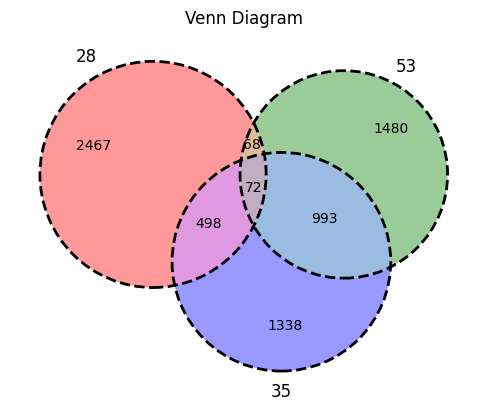

In [11]:
# sizes = { '100': 20, '010': 25, '001': 30, '110': 35, '101': 40, '011': 45, '111': 50 }
# 001 010 011 100 101 110 111
venn = venn3(subsets = sizes, set_labels = labels)
venn_circles = venn3_circles(subsets = sizes, linestyle = '--')

plt.title('Venn Diagram')
plt.show()

In [12]:
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels), id2label=id2label, label2id=label2id)

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\joeya\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-unc

In [13]:
SIZE = df_data.shape[0]

train_texts= list(df_data.text[:SIZE//2])
val_texts=   list(df_data.text[SIZE//2:(3*SIZE)//4 ])
test_texts=  list(df_data.text[(3*SIZE)//4:])

train_labels= list(df_data.label[:SIZE//2])
val_labels=   list(df_data.label[SIZE//2:(3*SIZE)//4])
test_labels=  list(df_data.label[(3*SIZE)//4:])

print(   len(train_texts), len(val_texts), len(test_texts)   )

4303 2152 2152


In [14]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings   = tokenizer(val_texts,   truncation=True, padding=True)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True)

In [15]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = MyDataset(train_encodings, train_labels)
val_dataset   = MyDataset(val_encodings,   val_labels)
test_dataset  = MyDataset(test_encodings,  test_labels)

In [17]:
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds  = pred.predictions.argmax(-1) 
    f1  = f1_score(labels, preds, average='macro') 
    acc = accuracy_score(labels, preds) 
    return {
        'Accuracy': acc,
        'F1': f1
    }

In [18]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir=f'{rlhf}-model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="epoch",
    ## fp16=True
    #load_best_model_at_end=True
)

In [19]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics= compute_metrics
)

In [20]:
res_train = trainer.train()
print(res_train)

Step,Training Loss,Validation Loss,Accuracy,F1
50,1.120100,1.016652,0.498606,0.389874
100,0.959600,0.912191,0.565056,0.540532
150,0.954800,0.895040,0.618030,0.597530
200,0.890000,0.831087,0.613383,0.588680
250,0.895700,0.884649,0.598048,0.593051
300,0.882400,0.861295,0.610130,0.607711
350,0.876100,0.844937,0.607807,0.609618
400,0.875800,0.758583,0.663104,0.654511
450,0.907400,0.781631,0.644981,0.646917
500,0.812900,0.754188,0.658922,0.657657


TrainOutput(global_step=1614, training_loss=0.72148990394753, metrics={'train_runtime': 442.759, 'train_samples_per_second': 29.156, 'train_steps_per_second': 3.645, 'total_flos': 1844210250834588.0, 'train_loss': 0.72148990394753, 'epoch': 3.0})


In [21]:
trainer.save_model(f'{rlhf}-model/final-trainer')
tokenizer.save_pretrained(f'{rlhf}-model/final-tokenizer')

('movie-model/final-tokenizer\\tokenizer_config.json',
 'movie-model/final-tokenizer\\special_tokens_map.json',
 'movie-model/final-tokenizer\\vocab.txt',
 'movie-model/final-tokenizer\\added_tokens.json',
 'movie-model/final-tokenizer\\tokenizer.json')

In [22]:
q = [trainer.evaluate(eval_dataset=data) for data in [train_dataset, val_dataset, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_runtime,eval_samples_per_second
train,0.445553,0.765512,0.768127,20.2032,212.986
val,0.755372,0.679368,0.676791,7.6373,281.774
test,0.775570,0.681227,0.672105,9.7206,221.386


In [23]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return probs, probs.argmax(),model.config.id2label[probs.argmax().item()]

In [24]:
text = ""
print(predict(text))

(tensor([[0.2187, 0.4693, 0.3120]], device='cuda:0', grad_fn=<SoftmaxBackward0>), tensor(1, device='cuda:0'), '53')


## Predict

In [25]:
model = BertForSequenceClassification.from_pretrained(f"{rlhf}-model/final-trainer")
tokenizer= BertTokenizerFast.from_pretrained(f"{rlhf}-model/final-tokenizer")

sent_kwargs = {
         "return_all_scores": True, 
         "function_to_apply": "none", 
         "batch_size": 16
}
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, **sent_kwargs)

C:\Users\joeya\anaconda3\envs\its520v2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [26]:
if rlhf == 'anime':
    text = "For hearing-impaired university student Yuki Itose, silence has been a natural part \
of life since birth. Her world is small and isolated; she commutes to campus, interacts with \
her best friend Rin Fujishiro, and communicates through writing and text messages—a lifestyle \
that offers little to no change. One day, during her commute, Yuki meets fellow student \
Itsuomi Nagi, a multilingual travel enthusiast and friend of Rin. When Itsuomi learns of \
Yuki's condition, he takes it in stride, moving Yuki's heart. From this one simple \
gesture, Yuki and Itsuomi's lives start changing day by day as they let each other into their own worlds."
elif rlhf == 'steam':
    text = "You work as a scientist in the isolated research lab in the mountains of Switzerland. \
Your task is to gather signals from space, analyze them, process them and sell them to get points. \
You can get regular signals and objects like dwarf planets and stars, or you can get something \
\"unusual\" or \"strange\" The game has 40+ days and events, 150+ possible signals, \
some easter eggs and secrets."
elif rlhf == 'movie':
    pass
# voices of the void
# https://mrdrnose.itch.io/votv

print(text)
r1 = nlp(text)
print(json.dumps(r1, indent='\t'))


[
	[
		{
			"label": "28",
			"score": -0.2838089168071747
		},
		{
			"label": "53",
			"score": 0.4798276424407959
		},
		{
			"label": "35",
			"score": 0.0714331567287445
		}
	]
]
